In [13]:
from utils import *

In [14]:
import torch
from torchvision import datasets, transforms

class TransferLearningMNIST(object):
    def __init__(self, batch_size, input_dim=28*28, val_split=0.1):
        self.input_dim = input_dim
        self.output_dim = 10
        self.val_split = val_split

        def filter_dataset(dataset, classes):
            indices = [i for i, t in enumerate(dataset.targets) if t in classes]
            return torch.utils.data.Subset(dataset, indices)
        
        mnist_train_data = datasets.MNIST(
            '../data',
            train=True,
            download=True,
            transform=transforms.Compose([
                transforms.ToTensor(),
                transforms.Lambda(lambda x: (x * 2 - 1) * 0.5),
            ]))

        pretrain_train_data = filter_dataset(mnist_train_data, list(range(5)))
        finetune_train_data = filter_dataset(mnist_train_data, list(range(5, 10)))

        pretrain_len = len(pretrain_train_data)
        finetune_len = len(finetune_train_data)
        pretrain_val_len = int(val_split * pretrain_len)
        finetune_val_len = int(val_split * finetune_len)

        pretrain_train_set, pretrain_val_set = torch.utils.data.random_split(
            pretrain_train_data, [pretrain_len - pretrain_val_len, pretrain_val_len])
        finetune_train_set, finetune_val_set = torch.utils.data.random_split(
            finetune_train_data, [finetune_len - finetune_val_len, finetune_val_len])

        self.pretrain_train_loader = torch.utils.data.DataLoader(pretrain_train_set, batch_size=batch_size, shuffle=True)
        self.pretrain_val_loader = torch.utils.data.DataLoader(pretrain_val_set, batch_size=batch_size, shuffle=False)
        self.finetune_train_loader = torch.utils.data.DataLoader(finetune_train_set, batch_size=batch_size, shuffle=True)
        self.finetune_val_loader = torch.utils.data.DataLoader(finetune_val_set, batch_size=batch_size, shuffle=False)

        # Separate test loaders
        mnist_test_data = datasets.MNIST(
            '../data',
            train=False,
            download=True,
            transform=transforms.Compose([
                transforms.ToTensor(),
                transforms.Lambda(lambda x: (x * 2 - 1) * 0.5),
            ]))

        pretrain_test_data = filter_dataset(mnist_test_data, list(range(5)))
        finetune_test_data = filter_dataset(mnist_test_data, list(range(5, 10)))

        self.pretrain_test_loader = torch.utils.data.DataLoader(pretrain_test_data, batch_size=batch_size, shuffle=False)
        self.finetune_test_loader = torch.utils.data.DataLoader(finetune_test_data, batch_size=batch_size, shuffle=False)
        self.complete_test_loader = torch.utils.data.DataLoader(mnist_test_data, batch_size=batch_size, shuffle=False)


In [15]:
import torch
import torch.optim as optim
import torch.nn.functional as F

class TransferLearningMNISTWrapper:
    def __init__(self, transferLearningMNISTObj, phase):
        self.transferLearningMNISTObj = transferLearningMNISTObj
        self.phase = phase
        self.input_dim = self.transferLearningMNISTObj.input_dim
        self.output_dim = self.transferLearningMNISTObj.output_dim
        self.update_phase(phase)
        
    def update_phase(self, phase):
        self.phase = phase
        if phase == 'pretrain':
            self.train_loader = self.transferLearningMNISTObj.pretrain_train_loader
            self.val_loader = self.transferLearningMNISTObj.pretrain_val_loader
            self.test_loader = self.transferLearningMNISTObj.pretrain_test_loader
        elif phase == 'finetune':
            self.train_loader = self.transferLearningMNISTObj.finetune_train_loader
            self.val_loader = self.transferLearningMNISTObj.finetune_val_loader
            self.test_loader = self.transferLearningMNISTObj.finetune_test_loader
        else:
            raise ValueError('Phase must be either "pretrain" or "finetune".')

In [16]:
def generate_fc_dnn(input_dim, output_dim, params):
    depth, width = params['depth'], params['width']
    def gen_linear_layer_dim(layer_index):
        return {
            0: (input_dim, width),
            depth - 1: (width, output_dim),
        }.get(layer_index, (width, width))

    fc_list = list()
    for i in range(depth):
        fc_list += [
            nn.Linear(*gen_linear_layer_dim(i)),
            nn.LogSoftmax(dim=1) if (depth - 1 == i) else nn.Tanh()
        ]
    model = nn.Sequential(*fc_list)
    #model.apply(lambda m: init_weights(m, params['sw'], params['sb']))
    return model

In [17]:
batch_size = 128
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = 'mps'
depth = 5

dataset = TransferLearningMNIST(batch_size)
dataset_wrapped = TransferLearningMNISTWrapper(dataset, 'pretrain')
params = dict(device=device,
                width=50, lr=0.01, num_train=4,
                sb=1, depth= depth, sw=1.5, early_stop_patience = 2)

model = generate_fc_dnn(dataset.input_dim, dataset.output_dim,
                params).to(device)

pretrain_train_acc, pretrain_test_acc, pre_trained_model = compute_training_acc_epochs(model, dataset_wrapped, params, debug=True)

Epoch: 0 	Training Accuracy: 22.10%
Validation Accuracy: 21.44%
Epoch: 1 	Training Accuracy: 41.41%
Validation Accuracy: 41.22%
Epoch: 2 	Training Accuracy: 69.27%
Validation Accuracy: 69.27%
Epoch: 3 	Training Accuracy: 88.71%
Validation Accuracy: 89.15%


In [18]:
test_acc = eval(pre_trained_model, device, dataset.pretrain_test_loader, False)
print(f"Test Accuracy on training classes: {test_acc:.2f}%")

test_acc_transfer = eval(pre_trained_model, device, dataset.finetune_test_loader, False)
print(f"Test Accuracy on finetuning classes: {test_acc_transfer:.2f}%")

Test Accuracy on training classes: 0.89%
Test Accuracy on finetuning classes: 0.00%


In [19]:
dataset_wrapped.update_phase('finetune')
cut_models = []

for cut in range(depth):
    temp = {}
    temp['cut_model'] = cut_model(pre_trained_model, sw = 1.5, sb = 1, cut_point = cut)
    finetuned_train_acc, finetuned_test_acc, finetuned_model = compute_training_acc_epochs(temp['cut_model'], dataset_wrapped, params, debug=True)
    temp['finetuned_train_acc'] = finetuned_train_acc
    temp['finetuned_test_acc'] = finetuned_test_acc
    temp['finetuned_model'] = finetuned_model
    cut_models.append(temp)   

Epoch: 0 	Training Accuracy: 73.21%
Validation Accuracy: 74.49%
Epoch: 1 	Training Accuracy: 83.59%
Validation Accuracy: 83.71%
Epoch: 2 	Training Accuracy: 87.89%
Validation Accuracy: 87.72%
Epoch: 3 	Training Accuracy: 89.93%
Validation Accuracy: 90.00%
Epoch: 0 	Training Accuracy: 57.77%
Validation Accuracy: 58.10%
Epoch: 1 	Training Accuracy: 69.55%
Validation Accuracy: 70.51%
Epoch: 2 	Training Accuracy: 75.39%
Validation Accuracy: 76.80%
Epoch: 3 	Training Accuracy: 79.60%
Validation Accuracy: 80.37%
Epoch: 0 	Training Accuracy: 55.61%
Validation Accuracy: 56.43%
Epoch: 1 	Training Accuracy: 61.05%
Validation Accuracy: 61.56%
Epoch: 2 	Training Accuracy: 64.00%
Validation Accuracy: 65.00%
Epoch: 3 	Training Accuracy: 67.67%
Validation Accuracy: 68.50%
Epoch: 0 	Training Accuracy: 49.88%
Validation Accuracy: 51.22%
Epoch: 1 	Training Accuracy: 55.54%
Validation Accuracy: 57.07%
Epoch: 2 	Training Accuracy: 57.20%
Validation Accuracy: 58.71%
Epoch: 3 	Training Accuracy: 58.77%
Vali

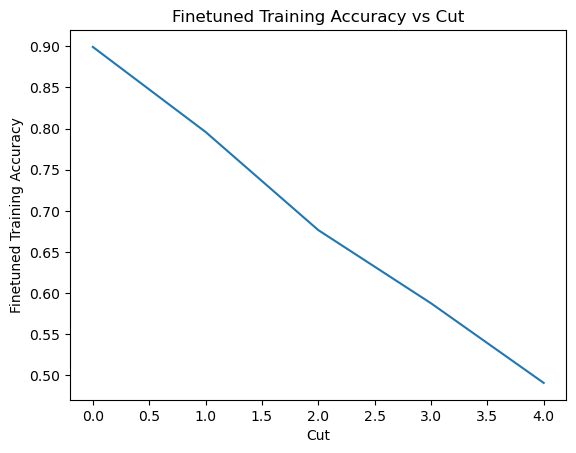

In [20]:
import matplotlib.pyplot as plt

finetuned_accs = [model['finetuned_train_acc'] for model in cut_models]
cuts = range(len(finetuned_accs))
plt.plot(cuts, finetuned_accs)
plt.xlabel('Cut')
plt.ylabel('Finetuned Training Accuracy')
plt.title('Finetuned Training Accuracy vs Cut')
plt.show()

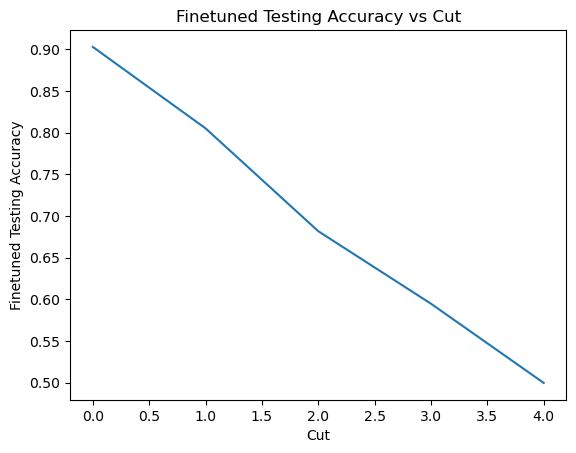

In [21]:
import matplotlib.pyplot as plt

finetuned_accs = [model['finetuned_test_acc'] for model in cut_models]
cuts = range(len(finetuned_accs))
plt.plot(cuts, finetuned_accs)
plt.xlabel('Cut')
plt.ylabel('Finetuned Testing Accuracy')
plt.title('Finetuned Testing Accuracy vs Cut')
plt.show()

-----

## Fashion Mnist

### Baseline, end to end trained model

In [4]:
batch_size = 128
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = 'mps'
depth = 5

fashion_dataset = FashionMNISTtrainer(batch_size)
params = dict(device=device,
                width=50, lr=0.01, num_train=4,
                sb=1, depth= depth, sw=1.5)

fashion_model = generate_fc_dnn(dataset.input_dim, dataset.output_dim,
                params['depth'], params['width']).to(device)

pretrain_acc, pre_trained_model = compute_training_acc_epochs(fashion_model, fashion_dataset, params, debug=True)

Sequential(
  (0): Linear(in_features=784, out_features=50, bias=True)
  (1): Tanh()
  (2): Linear(in_features=50, out_features=50, bias=True)
  (3): Tanh()
  (4): Linear(in_features=50, out_features=50, bias=True)
  (5): Tanh()
  (6): Linear(in_features=50, out_features=50, bias=True)
  (7): Tanh()
  (8): Linear(in_features=50, out_features=10, bias=True)
  (9): LogSoftmax(dim=1)
) SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.01
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)

Train set: Average loss: 0.8191, Accuracy: 42975.0/60000 (72%)

Epoch: 0 	Training Accuracy: 71.62%

Train set: Average loss: 0.6768, Accuracy: 45237.0/60000 (75%)

Epoch: 1 	Training Accuracy: 75.39%

Train set: Average loss: 0.6093, Accuracy: 46827.0/60000 (78%)

Epoch: 2 	Training Accuracy: 78.05%

Train set: Average loss: 0.5691, Accuracy: 47610.0/60000 (79%)

Epoch: 3 	Training Accuracy: 79.35%

Train set: Average loss: 0.5691, 

### finetuned staring from regular mnist 

In [6]:
#luckily, the number of classes is the same, so we don't need to change the last layer.

cut_models = []

for cut in range(depth):
    temp = {}
    temp['cut_model'] = cut_model(model, sw = 1.5, sb = 1, cut_point = cut)
    finetuned_acc, finetuned_model = compute_training_acc_epochs(temp['cut_model'], fashion_dataset, params, debug=False)
    temp['finetuned_acc'] = finetuned_acc
    temp['finetuned_model'] = finetuned_model
    cut_models.append(temp)   

In [9]:
from pprint import pprint

for i, mod in enumerate(cut_models):
    print(f"Cut {i}:")
    pprint(mod['finetuned_acc'])

Cut 0:
0.7911
Cut 1:
0.7381833333333333
Cut 2:
0.6858333333333333
Cut 3:
0.6187833333333334
Cut 4:
0.27591666666666664


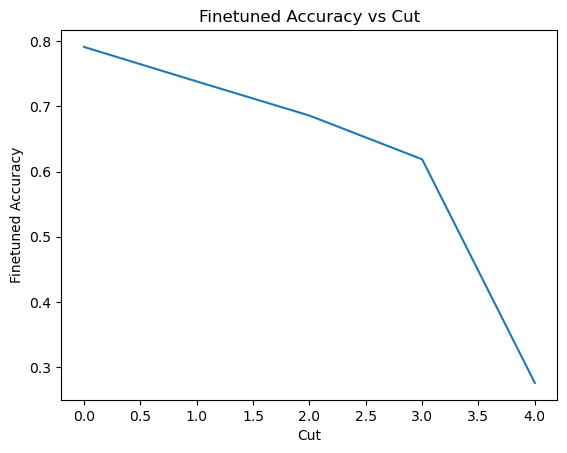

In [7]:
import matplotlib.pyplot as plt

finetuned_accs = [model['finetuned_acc'] for model in cut_models]
cuts = range(len(finetuned_accs))
plt.plot(cuts, finetuned_accs)
plt.xlabel('Cut')
plt.ylabel('Finetuned Accuracy')
plt.title('Finetuned Accuracy vs Cut')
plt.show()

----